
# Google Landmark Recognition Challenge

### by-
   ### Sufiyan Adhikari (173190009)
   ### Jaswant Singh    (173190020)
   ### Khyati Thakkar   (173194001)


In [1]:
import pandas as pd
train = pd.read_csv("data/train.csv")
train.head()

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


# Data Handling

### Data Sampling

As Data size is Huge and Data is [Highly Skewed](https://www.kaggle.com/codename007/a-very-extensive-landmark-exploratory-analysis),  
Sampling was required to make sure everything works before training on whole data.

train: 336 GB with 1,220,165 images 
test: 34.9 GB with 116,163 images

Data was downloaded [with]() this script, reducing the resolution to *299* from *1600*
as demonstrated 

In [2]:
def show_count(train):
    temp = pd.DataFrame(train.landmark_id.value_counts())
    temp.reset_index(inplace=True)
    temp.columns = ['landmark_id','count1']
    temp = pd.DataFrame(temp.count1.value_counts())
    temp = temp.sort_index()
    temp.reset_index(inplace=True)
    temp.columns = ["Photos","Id Count"]
    print("Landmark IDs with Very Few Photos: \n")
    print(temp.head())
    print("\n\nLandmarks IDs with Very High Number of Photos \n")
    print(temp.tail())
show_count(train)

Landmark IDs with Very Few Photos: 

   Photos  Id Count
0       1       159
1       2       291
2       3       631
3       4       999
4       5      1314


Landmarks IDs with Very High Number of Photos 

     Photos  Id Count
759   13271         1
760   18471         1
761   23415         1
762   50148         1
763   50337         1


In [3]:
!ls data

image_data  sample_submission.csv  test.csv  train_100	valid
models	    temp_1		   tmp	     train_40
planet	    test		   train     train.csv


In [4]:
import os
HOME = os.getenv("HOME")
os.chdir(HOME)

### Reducing Train Data and Extracting Validation Data
As we can see above, 159 Landmark IDs have only 1 photo, 259 have only 2 photos, etc.
where as, a few IDs have photos in excess of several thousand.
The Below function was written to take in the original train.csv file and reduce it to include maximum *trn_sz* photos of each landmark for training, and also generate maximum *val_sz* of validation photo indexes of each landmark if it has more than *trn*sz* photos and save it in a python list as required by **fastai** library

It Dumps these into a pickle file with name train_val_<trn_sz>_<val_sz>.pkl

and can be imported as *train, val_idxs = joblib.load(filename)*

missing_in_train = []
for i, row in train.iterrows():
    filename = f'{HOME}/data/train/{row["id"]}.jpg'
    if not os.path.exists(filename): 
        missing_in_train.append(i)
    elif 0 == os.path.getsize(filename):
        #Deleting the empty files
        os.unlink(filename)
        missing_in_train.append(i)
print("Number of Photos Not Downloaded: ", len(missing_in_train))

os.chdir(HOME)
train.drop(index=missing_in_train, inplace=True)
train.to_csv("data/train.csv", index=False)

In [5]:
os.chdir("data")
train_data = pd.read_csv('train.csv')
print("Actual Training Data Size: ",train_data.shape)
temp=pd.DataFrame(train_data.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
os.chdir(HOME)

Actual Training Data Size:  (1225029, 3)


In [6]:
train_data = pd.read_csv('data/train.csv')
print("Actual Training Data Size: ",train_data.shape)
temp=pd.DataFrame(train_data.landmark_id.value_counts())
temp.reset_index(inplace=True)
temp.columns = ['landmark_id','count']
temp.head()

Actual Training Data Size:  (1225029, 3)


,landmark_id,count
0,9633,50337
1,6051,50148
2,6599,23415
3,9779,18471
4,2061,13271


In [7]:
train.head()

,id,url,landmark_id
0,cacf8152e2d2ae60,http://static.panoramio.com/photos/original/70...,4676
1,0a58358a2afd3e4e,http://lh6.ggpht.com/-igpT6wu0mIA/ROV8HnUuABI/...,6651
2,6b2bb500b6a38aa0,http://lh6.ggpht.com/-vKr5G5MEusk/SR6r6SJi6mI/...,11284
3,b399f09dee9c3c67,https://lh3.googleusercontent.com/-LOW2cjAqubA...,8429
4,19ace29d77a5be66,https://lh5.googleusercontent.com/-tnmSXwQcWL8...,6231


## Training Starts Here

In [8]:
#To add fastai to system path
import sys
sys.path.append(f'{HOME}/fastai')



# This file contains all the main external libs we'll use
from fastai.imports import *

from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

PATH = f'{HOME}/data/'
sz=64
arch = resnet34
bs=64


In [9]:
torch.cuda.is_available()

True

In [10]:
os.chdir(f'{PATH}train')

In [11]:
tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
data = ImageClassifierData.from_paths(PATH, tfms=tfms, bs=bs, num_workers=8)
learn = ConvLearner.pretrained(arch, data, precompute=True, ps=0.5)
    

100%|██████████| 155/155 [00:19<00:00,  7.78it/s]


 80%|███████▉  | 14828/18563 [10:29<02:38, 23.56it/s, loss=23.1]

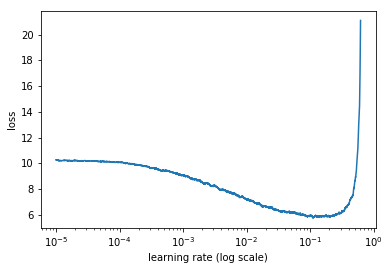

In [12]:
lrf=learn.lr_find()
learn.sched.plot()

In [13]:
lr = 0.05

In [14]:
learn.fit(lr, 1)

  2%|▏         | 434/18563 [00:07<05:27, 55.33it/s, loss=8.35]
epoch      trn_loss   val_loss   accuracy                       
    0      4.990365   11.734937  0.000101  



[array([11.73494]), 0.00010082677959265981]

In [15]:
learn.save(f'model_{sz}_1')

In [16]:
learn.precompute=False
learn.fit(lr, 2, cycle_len=1)
learn.save(f'model_{sz}_2')

epoch      trn_loss   val_loss   accuracy                       
    0      4.84581    12.167926  0.000101  
    1      4.616157   12.441432  0.000101                       



### OverFitting Model
We can see from above that the model is overfitting.
This is probably due to some landmarks have a lot more photos that the others.
Skewed Dataset needs to be handelled.
Our Solution:
Limiting max photos of each landmark to 30
Creating *hard links* of photos if photos of a landmark are below 30.

In [ ]:
import os
import random
HOME=os.getenv("HOME")
PATH = f'{HOME}/data'
TRAIN = f'{PATH}/train'
EXTRA = f'{PATH}/extra'
dir_list = os.listdir(f'{PATH}/train')
for some_dir in dir_list:
    files = os.listdir(f'{PATH}/train/{some_dir}')
    if len(files)>30:
        for file in files[30:]:
            os.renames(f'{TRAIN}/{some_dir}/{file}', f'{EXTRA}/{some_dir}/{file}')
    elif len(files)<30:
        count=len(files)
        while count <30:
            for file in files:
                if count<30:  
                    os.link(f'{TRAIN}/{some_dir}/{file}', 
                        f"{TRAIN}/{some_dir}/{'%020x' % random.randrange(16**20)}.jpg")
                    count+=1
print("Done Setting Data!")

In [17]:
learn.unfreeze()
lr=np.array([lr/9,lr/3,lr])
learn.fit(lr, 3, cycle_len=1)
learn.save(f'model_{sz}_3')

epoch      trn_loss   val_loss   accuracy                         
    0      2.731841   14.086988  0.000202  
    1      2.250377   15.120018  0.000202                         
 39%|███▉      | 7328/18563 [25:47<39:33,  4.73it/s, loss=2.23]  

KeyboardInterrupt: 